In [1]:
import pandas as pd
import numpy as np
import re
import random
import time
import demoji
import string

import nltk
from nltk.corpus import stopwords, wordnet

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.optim import Adam

from transformers import MobileBertTokenizer, MobileBertModel
from transformers import MobileBertForSequenceClassification


from gensim.models import Word2Vec

import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense
from keras.initializers import Constant

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

<a id="models"></a>

<strong><center><h1><div class="top_section" style="background-color: Pink;">Word2Vec</div></h1></center></strong>

# Preprocessing 

In [2]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

class TextProcessor:
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        # Assume that the demoji library is installed and can be used.
        # If not, the remove_emoji method should be modified to handle emojis appropriately.
        self.demoji = demoji

    def clean_text(self, text):
        text = re.sub(r'[^A-Za-z0-9."\' ]', ' ', text)
        text = ' '.join(text.split())
        text = ' '.join([word for word in text.split() if word not in self.stopwords])
        return text

    def remove_emoji(self, text):
        return self.demoji.replace(text, '')

    def process_text(self, text):
        text = self.remove_emoji(text)
        text = text.lower()
        text = self.clean_text(text)
        text = text.replace('"', '') 
        return text

# Additional functions
def label_encode_1to5(rating):
    if rating in [1, 2]:
        return 0
    elif rating == 3:
        return 1
    elif rating in [4, 5]:
        return 2

def label_encode_1to10(rating):
    if rating <= 3.3:
        return 0
    elif rating <= 6.6:
        return 1
    else:
        return 2
    
def label2name_1to5(label):
    return ["Negative", "Neutral", "Positive"][label]

def label2name_1to10(label):
    return ["Negative", "Neutral", "Positive"][label]

def remove_punct(text):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    return regex.sub(" ", text)

# Wordcloud function
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


In [3]:
#Import Dataset 1
file_path1 = '/Users/jane/Desktop/tripadvisor_hotel_reviews.csv'
df1 = pd.read_csv(file_path1) 
df1.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
#Import Dataset 2
file_path2 = '/Users/jane/Desktop/booking_hotel_reviews_english.csv'
df2 = pd.read_csv(file_path2) 
df2.head()

,review,Review Rating
0,"“Location was Great, Staff were lovely but the...",5.4
1,“Very good” Excellent location,9.2
2,"“Great getaway” Love the location, great staff...",10.0
3,“Great place” 2min from the beach and restaura...,7.5
4,"“Good stay” The location, the facilities, it w...",7.1


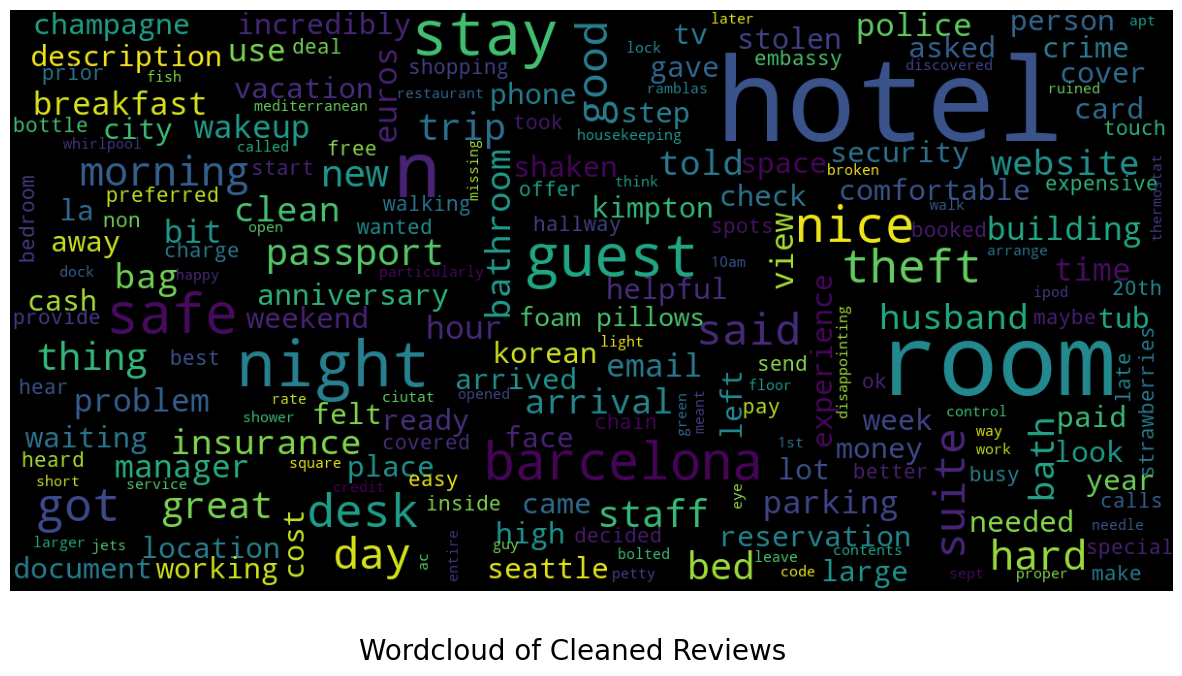

In [5]:
#Initialize dataset 1
processor = TextProcessor()

# Encoding and Data cleaning 
df1["label"] = df1["Rating"].apply(label_encode_1to5)
df1["label_name"] = df1["label"].apply(label2name_1to5)
df1["cleaned_review"] = df1["Review"].apply(lambda x: processor.process_text(remove_punct(x.lower())))

# Show wordcloud after data preprocessing and cleaning 
show_wordcloud(df1["cleaned_review"].values, title="Wordcloud of Cleaned Reviews")


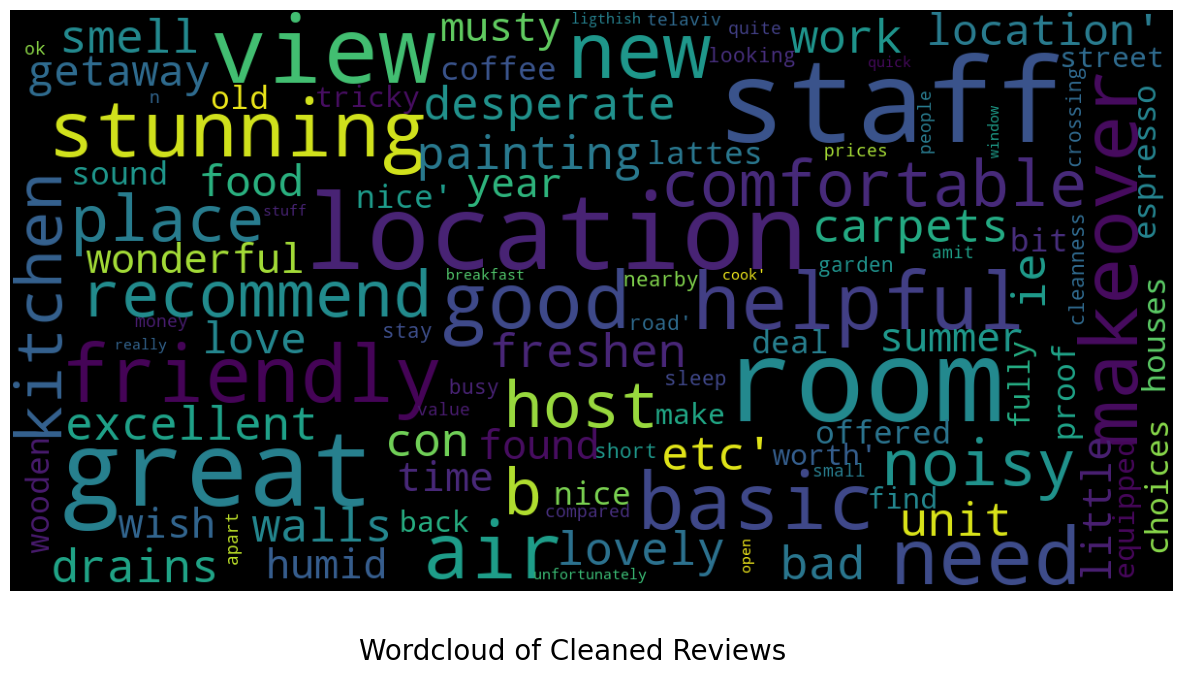

In [6]:
# Encoding and Data cleaning 
df2["label"] = df2["Review Rating"].apply(label_encode_1to10)
df2["label_name"] = df2["label"].apply(label2name_1to10)
df2["cleaned_review"] = df2["review"].apply(lambda x: processor.process_text(remove_punct(x.lower())))

# Show wordcloud after data preprocessing and cleaning 
show_wordcloud(df2["cleaned_review"].values, title="Wordcloud of Cleaned Reviews")

In [7]:
#Data Augmentation 

def synonym_replacement(text, n):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:  # n is the number of words you want to replace
            break

    sentence = ' '.join(new_words)
    return sentence

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def random_insertion(text, n):
    words = text.split()
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        if new_synonym:
            words.insert(random.randint(0, len(words)), new_synonym[0])
    sentence = ' '.join(words)
    return sentence

def random_swap(text, n=2):
    words = text.split()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1] 
    sentence = ' '.join(words)
    return sentence


def random_deletion(text, p=0.5):
    if len(text.split()) == 1:  # return if single word
        return text
    words = text.split()
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:  # if all words are deleted, return a random word
        return random.choice(words)
    sentence = ' '.join(new_words)
    return sentence

def augment_text(text, methods):
    """
    Perform data augmentation on the input text by applying a series of augmentation methods.
    
    Args:
    text (str): The input text.
    methods (list): A list of tuples, where each tuple contains the augmentation method name as the first element and its parameters as the second element.

    Returns:
    str: The augmented text.
    """
    for method, params in methods:
        if method == "synonym_replacement":
            text = synonym_replacement(text, **params)
        elif method == "random_insertion":
            text = random_insertion(text, **params)
        elif method == "random_swap":
            text = random_swap(text, **params)
        elif method == "random_deletion":
            text = random_deletion(text, **params)
        else:
            raise ValueError("Unknown augmentation method: " + method)
    return text

methods_to_apply = [
    ("synonym_replacement", {"n": 1}),
    ("random_insertion", {"n": 1}),
    ("random_swap", {"n": 2}),
    ("random_deletion", {"p": 0.5})]




In [8]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

#split dataset 1
train_df, test_df = train_test_split(df1, test_size=0.1, random_state=42)

indices_to_augment = train_df.sample(frac=0.2).index  # 20% for augmentation 
train_df.loc[indices_to_augment, 'augmented_review'] = train_df.loc[indices_to_augment, 'cleaned_review'].apply(lambda x: augment_text(x, methods=methods_to_apply))


# Tokenization
train_df['tokenized'] = train_df['cleaned_review'].apply(lambda x: x.split())
test_df['tokenized'] = test_df['cleaned_review'].apply(lambda x: x.split())

# Logistic Regression Model

In [9]:
# Training the Word2Vec model
model_w2v = Word2Vec(sentences=train_df['tokenized'], vector_size=1000, window=5, min_count=1, workers=4)

# Function to build feature vectors by averaging word vectors
def document_vector(word2vec_model, doc):
    # Remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv]
    
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    try:
        return np.mean(word2vec_model.wv[doc], axis=0)
    except ValueError:
        return np.zeros(word2vec_model.vector_size)


# Vectorize documents using the model (Handle empty documents after preprocessing)
def mean_vectorizer(sent, model_w2v):
    if len(sent) == 0:
        return np.zeros(model_w2v.vector_size)
    else:
        return document_vector(model_w2v, sent)

# Vectorization of the reviews
train_df['doc_vector'] = train_df['tokenized'].apply(lambda x: mean_vectorizer(x, model_w2v))
test_df['doc_vector'] = test_df['tokenized'].apply(lambda x: mean_vectorizer(x, model_w2v))


In [10]:
# Convert document vectors into a better format 
X_train = np.vstack(train_df['doc_vector'].values)
y_train = train_df['label'].values
X_test = np.vstack(test_df['doc_vector'].values)
y_test = test_df['label'].values

word2vec_start_time = time.time()

# Train the classifier
classifier_df1 = LogisticRegression(max_iter=1000)
classifier_df1.fit(X_train, y_train)

word2vec_end_time = time.time()  
word2vec_training_time = word2vec_end_time - word2vec_start_time 
print(f"Word2vec+LR Model training took {word2vec_training_time} seconds.")

# Predictions
y_pred = classifier_df1.predict(X_test)

# Model evaluation
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Word2vec+LR Model training took 15.78361701965332 seconds.
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       309
           1       0.58      0.18      0.28       216
           2       0.89      0.97      0.93      1525

    accuracy                           0.86      2050
   macro avg       0.74      0.64      0.65      2050
weighted avg       0.84      0.86      0.83      2050

Accuracy: 0.8575609756097561


In [11]:
# Tokenization
df2['tokenized'] = df2['cleaned_review'].apply(lambda x: x.split())

# Vectorization of the reviews
df2['doc_vector'] = df2['tokenized'].apply(lambda x: mean_vectorizer(x, model_w2v))

# Convert document vectors into a better format 
X_df2 = np.vstack(df2['doc_vector'].values)
y_df2 = df2['label'].values

# Predictions for df2
classifier_df2 = LogisticRegression(max_iter=1000)
classifier_df2.fit(X_df2, y_df2)
y_pred_df2 = classifier_df2.predict(X_df2)

# Model evaluation for df2
print(classification_report(y_df2, y_pred_df2))
print("Accuracy for df2:", accuracy_score(y_df2, y_pred_df2))

              precision    recall  f1-score   support

           0       0.62      0.30      0.41       165
           1       0.59      0.45      0.51       576
           2       0.88      0.96      0.92      2678

    accuracy                           0.84      3419
   macro avg       0.70      0.57      0.61      3419
weighted avg       0.82      0.84      0.82      3419

Accuracy for df2: 0.8391342497806377


In [12]:
out_of_vocab = [word for word in df2['tokenized'].explode().unique() if word not in model_w2v.wv]
print(f"Number of out-of-vocabulary words: {len(out_of_vocab)}")

Number of out-of-vocabulary words: 1564


In [13]:
# Display the accuracy data

train_accuracy_df1 = accuracy_score(y_train, classifier_df1.predict(X_train)) * 100
test_accuracy_df1 = accuracy_score(y_test, y_pred) * 100
test_accuracy_df2 = accuracy_score(y_df2, y_pred_df2) * 100

accuracy_data_percentage = pd.DataFrame({
    'Model': ['Word2Vec + LR'],
    'df1 Train Accuracy': [f'{train_accuracy_df1:.2f}%'],
    'df1 Test Accuracy': [f'{test_accuracy_df1:.2f}%'],
    'df2 Test Accuracy': [f'{test_accuracy_df2:.2f}%']
})

accuracy_data_percentage.index = accuracy_data_percentage.index + 1

styled_accuracy_data = accuracy_data_percentage.style \
    .set_properties(**{'border': '1px solid black',
                      'border-collapse': 'collapse',
                      'text-align': 'center'})

styled_accuracy_data


,Model,df1 Train Accuracy,df1 Test Accuracy,df2 Test Accuracy
1,Word2Vec + LR,84.58%,85.76%,83.91%


# Deep Learning Model 

In [14]:
# Define the Keras model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(128, activation='relu'))  # Hidden layer
model.add(Dropout(0.5))  # Another Dropout layer
model.add(Dense(3, activation='softmax'))  # Output layer, 3 units for 3 classes

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
word2vec_dl_start_time = time.time()
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=2)
word2vec_dl_end_time = time.time()
word2vec_dl_training_time = word2vec_dl_end_time - word2vec_dl_start_time
print(f"Word2Vec+Deep Learning Model training took {word2vec_dl_training_time} seconds.")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy}")

# Predictions
y_pred_dl = model.predict(X_test)
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)

# Model evaluation
print(classification_report(y_test, y_pred_dl_classes))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 289539 (1.10 MB)
Trainable params: 289539 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
260/260 -

In [15]:
# df2
y_pred_dl_df2 = model.predict(X_df2)

y_pred_dl_classes_df2 = np.argmax(y_pred_dl_df2, axis=1)

print(classification_report(y_df2, y_pred_dl_classes_df2))
print("Accuracy for df2:", accuracy_score(y_df2, y_pred_dl_classes_df2))


107/107 [==============================] - 0s 662us/step
              precision    recall  f1-score   support

           0       0.20      0.92      0.33       165
           1       0.22      0.06      0.09       576
           2       0.92      0.86      0.89      2678

    accuracy                           0.73      3419
   macro avg       0.45      0.61      0.44      3419
weighted avg       0.77      0.73      0.73      3419

Accuracy for df2: 0.7279906405381691


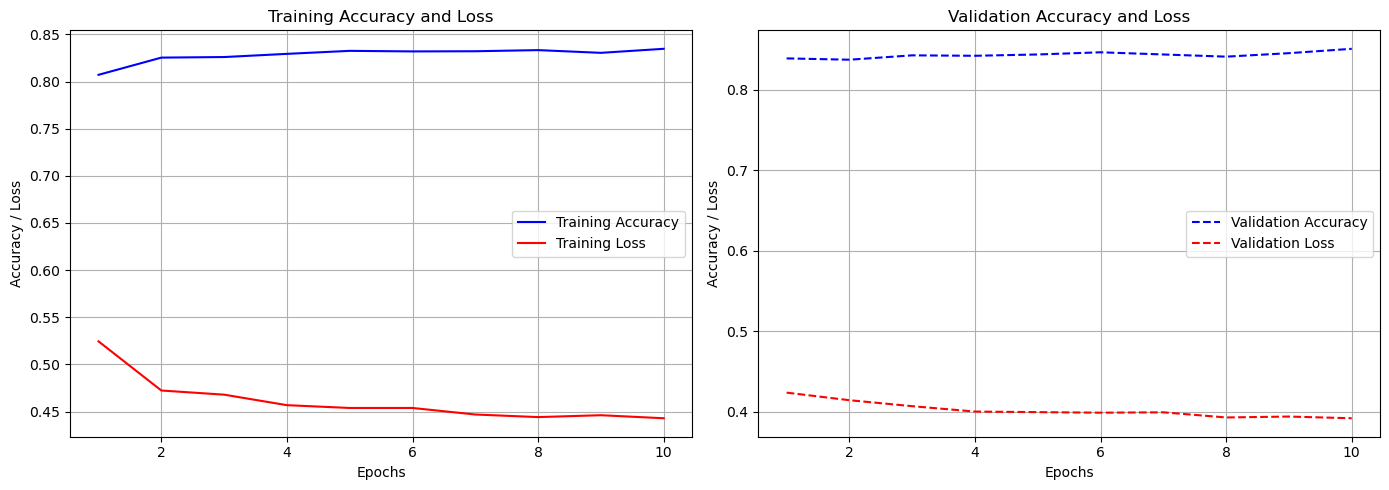

In [16]:
#plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

df2_test_accuracy = accuracy_score(y_df2, y_pred_dl_classes_df2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epochs, acc, 'b', label='Training Accuracy')
axes[0].plot(epochs, loss, 'r', label='Training Loss')
axes[0].set_title('Training Accuracy and Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy / Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
axes[1].plot(epochs, val_loss, 'r--', label='Validation Loss')
axes[1].set_title('Validation Accuracy and Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy / Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [17]:
last_epoch_accuracy_train = history.history['accuracy'][-1]
last_epoch_accuracy_test = history.history['val_accuracy'][-1]
test_accuracy_df2 = accuracy_score(y_df2, y_pred_dl_classes_df2) * 100


word2vec_dl_data = pd.DataFrame({
    'Model': ['Word2Vec + DL'],
    'df1 Train Accuracy': [f'{last_epoch_accuracy_train * 100:.2f}%'],
    'df1 Test Accuracy': [f'{last_epoch_accuracy_test * 100:.2f}%'],
    'df2 Test Accuracy': [f'{test_accuracy_df2:.2f}%']
})

accuracy_data_percentage = pd.concat([accuracy_data_percentage, word2vec_dl_data], ignore_index=True)

accuracy_data_percentage

,Model,df1 Train Accuracy,df1 Test Accuracy,df2 Test Accuracy
0,Word2Vec + LR,84.58%,85.76%,83.91%
1,Word2Vec + DL,83.47%,85.09%,72.80%


<a id="models"></a>

<strong><center><h1><div class="top_section" style="background-color: Green;">TF-IDF</div></h1></center></strong>

# LR Model 

In [18]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Train and transform train set text
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_review']).toarray()

# Only transform test set text
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_review']).toarray()

# Labels
y_train = train_df['label'].values
y_test = test_df['label'].values

# TF-IDF + Logistic Regression Model Training
tfidf_start_time = time.time()

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_tfidf, y_train)

tfidf_end_time = time.time()
tfidf_training_time = tfidf_end_time - tfidf_start_time
print(f"TF-IDF + LR Model training took {tfidf_training_time} seconds.")

# Predictions
y_pred_tfidf = classifier.predict(X_test_tfidf)

# Model Evaluation
print(classification_report(y_test, y_pred_tfidf))
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))


TF-IDF + LR Model training took 5.235234260559082 seconds.
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       309
           1       0.47      0.20      0.28       216
           2       0.89      0.97      0.93      1525

    accuracy                           0.86      2050
   macro avg       0.71      0.64      0.66      2050
weighted avg       0.83      0.86      0.84      2050

Accuracy: 0.8565853658536585


In [19]:
# df2
X_df2_tfidf = tfidf_vectorizer.transform(df2['cleaned_review']).toarray()

y_pred_tfidf_df2 = classifier.predict(X_df2_tfidf)


print(classification_report(y_df2, y_pred_tfidf_df2))
print("Accuracy for df2:", accuracy_score(y_df2, y_pred_tfidf_df2))


              precision    recall  f1-score   support

           0       0.19      0.91      0.31       165
           1       0.25      0.10      0.15       576
           2       0.93      0.83      0.88      2678

    accuracy                           0.71      3419
   macro avg       0.46      0.62      0.45      3419
weighted avg       0.78      0.71      0.73      3419

Accuracy for df2: 0.713366481427318


In [20]:
tfidf_lr_test_accuracy = accuracy_score(y_test, y_pred_tfidf) * 100
tfidf_lr_training_time = tfidf_training_time

tfidf_lr_data = pd.DataFrame({
    'Model': ['TF-IDF + LR'],
    'df1 Train Accuracy': [f'{accuracy_score(y_train, classifier.predict(X_train_tfidf)) * 100:.2f}%'],
    'df1 Test Accuracy': [f'{tfidf_lr_test_accuracy:.2f}%'],
    'df2 Test Accuracy': [f'{accuracy_score(y_df2, y_pred_tfidf_df2) * 100:.2f}%']
})

accuracy_data_percentage = pd.concat([accuracy_data_percentage, tfidf_lr_data], ignore_index=True)
accuracy_data_percentage

,Model,df1 Train Accuracy,df1 Test Accuracy,df2 Test Accuracy
0,Word2Vec + LR,84.58%,85.76%,83.91%
1,Word2Vec + DL,83.47%,85.09%,72.80%
2,TF-IDF + LR,87.52%,85.66%,71.34%


# Deep Learning Model 

In [21]:
# Define the Keras model for TF-IDF
model_tfidf = Sequential()
model_tfidf.add(Dense(256, input_dim=X_train_tfidf.shape[1], activation='relu'))  # Input layer
model_tfidf.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model_tfidf.add(Dense(128, activation='relu'))  # Hidden layer
model_tfidf.add(Dropout(0.5))  # Another Dropout layer
model_tfidf.add(Dense(3, activation='softmax'))  # Output layer, 3 units for 3 classes

# Compile the model
model_tfidf.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
                    metrics=['accuracy'])

# Model summary
model_tfidf.summary()

# Train the model
tfidf_dl_start_time = time.time()

history_tfidf = model_tfidf.fit(X_train_tfidf, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=2)

tfidf_dl_end_time = time.time()
tfidf_dl_training_time = tfidf_dl_end_time - tfidf_dl_start_time
print(f"TF-IDF+Deep Learning Model training took {tfidf_dl_training_time} seconds.")

# Evaluate the model
loss_tfidf, accuracy_tfidf = model_tfidf.evaluate(X_test_tfidf, y_test, verbose=0)
print(f"Test Accuracy: {accuracy_tfidf}")

# Predictions
y_pred_tfidf_dl = model_tfidf.predict(X_test_tfidf)
y_pred_tfidf_dl_classes = np.argmax(y_pred_tfidf_dl, axis=1)

# Model evaluation
print(classification_report(y_test, y_pred_tfidf_dl_classes))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               256256    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 289539 (1.10 MB)
Trainable params: 289539 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
260/260

In [22]:
#df 2
y_pred_tfidf_dl_df2 = model_tfidf.predict(X_df2_tfidf)

y_pred_tfidf_dl_classes_df2 = np.argmax(y_pred_tfidf_dl_df2, axis=1)

print(classification_report(y_df2, y_pred_tfidf_dl_classes_df2))
print("Accuracy for df2:", accuracy_score(y_df2, y_pred_tfidf_dl_classes_df2))


107/107 [==============================] - 0s 656us/step
              precision    recall  f1-score   support

           0       0.17      0.88      0.29       165
           1       0.22      0.19      0.20       576
           2       0.95      0.74      0.83      2678

    accuracy                           0.65      3419
   macro avg       0.45      0.60      0.44      3419
weighted avg       0.79      0.65      0.70      3419

Accuracy for df2: 0.6545773618016965


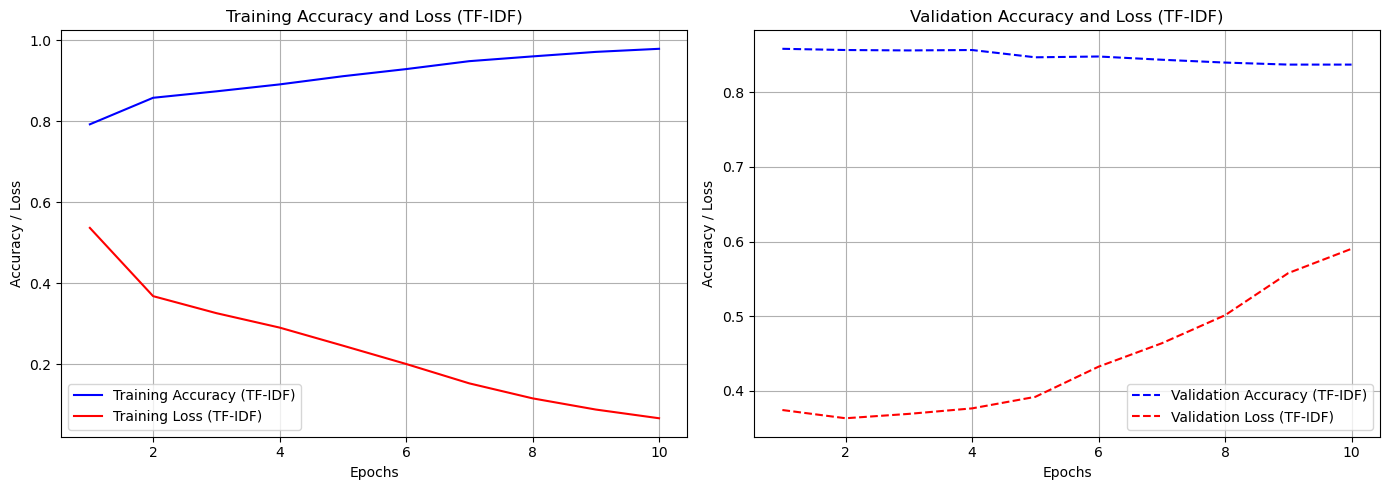

In [23]:
#plot
acc_tfidf = history_tfidf.history['accuracy']
val_acc_tfidf = history_tfidf.history['val_accuracy']
loss_tfidf = history_tfidf.history['loss']
val_loss_tfidf = history_tfidf.history['val_loss']
epochs_tfidf = range(1, len(acc_tfidf) + 1)

df2_test_accuracy_tfidf = accuracy_score(y_df2, y_pred_tfidf_dl_classes_df2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs_tfidf, acc_tfidf, 'b', label='Training Accuracy (TF-IDF)')
ax1.plot(epochs_tfidf, loss_tfidf, 'r', label='Training Loss (TF-IDF)')
ax1.set_title('Training Accuracy and Loss (TF-IDF)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy / Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_tfidf, val_acc_tfidf, 'b--', label='Validation Accuracy (TF-IDF)')
ax2.plot(epochs_tfidf, val_loss_tfidf, 'r--', label='Validation Loss (TF-IDF)')
ax2.set_title('Validation Accuracy and Loss (TF-IDF)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy / Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [24]:
last_epoch_accuracy_tfidf_dl = history_tfidf.history['accuracy'][-1]
tfidf_dl_test_accuracy = accuracy_tfidf * 100


tfidf_dl_data = pd.DataFrame({
    'Model': ['TF-IDF + DL'],
    'df1 Train Accuracy': [f'{last_epoch_accuracy_tfidf_dl * 100:.2f}%'],
    'df1 Test Accuracy': [f'{tfidf_dl_test_accuracy:.2f}%'],
    'df2 Test Accuracy': [f'{accuracy_score(y_df2, y_pred_tfidf_dl_classes_df2) * 100:.2f}%']
})

accuracy_data_percentage = pd.concat([accuracy_data_percentage, tfidf_dl_data], ignore_index=True)

accuracy_data_percentage


,Model,df1 Train Accuracy,df1 Test Accuracy,df2 Test Accuracy
0,Word2Vec + LR,84.58%,85.76%,83.91%
1,Word2Vec + DL,83.47%,85.09%,72.80%
2,TF-IDF + LR,87.52%,85.66%,71.34%
3,TF-IDF + DL,97.87%,84.10%,65.46%


# CNN Model 

In [27]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_review']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_review']).toarray()
y_train = train_df['label'].values
y_test = test_df['label'].values

# Define CNN model
model = Sequential()
model.add(Embedding(input_dim=len(tfidf_vectorizer.get_feature_names_out()), output_dim=64, input_length=X_train_tfidf.shape[1]))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train_tfidf, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tfidf, y_test, verbose=0)
print(f"Test Accuracy: {accuracy}")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 64)          64000     
                                                                 
 conv1d_2 (Conv1D)           (None, 996, 64)           20544     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                      

In [28]:
# Predictions
y_pred_cnn = model.predict(X_test_tfidf)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Model evaluation
print(classification_report(y_test, y_pred_cnn_classes))
print("Accuracy:", accuracy_score(y_test, y_pred_cnn_classes))

65/65 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       309
           1       0.00      0.00      0.00       216
           2       0.74      1.00      0.85      1525

    accuracy                           0.74      2050
   macro avg       0.25      0.33      0.28      2050
weighted avg       0.55      0.74      0.63      2050

Accuracy: 0.7439024390243902


/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
#df2

X_df2_tfidf = tfidf_vectorizer.transform(df2['cleaned_review']).toarray()
y_df2 = df2['label'].values

y_pred_df2_tfidf_dl = model_tfidf.predict(X_df2_tfidf)
y_pred_df2_tfidf_dl_classes = np.argmax(y_pred_df2_tfidf_dl, axis=1)


print(classification_report(y_df2, y_pred_df2_tfidf_dl_classes))
print("Accuracy for df2:", accuracy_score(y_df2, y_pred_df2_tfidf_dl_classes))


107/107 [==============================] - 0s 729us/step
              precision    recall  f1-score   support

           0       0.17      0.88      0.29       165
           1       0.22      0.19      0.20       576
           2       0.95      0.74      0.83      2678

    accuracy                           0.65      3419
   macro avg       0.45      0.60      0.44      3419
weighted avg       0.79      0.65      0.70      3419

Accuracy for df2: 0.6545773618016965


In [34]:
final_train_accuracy = history.history['accuracy'][-1] * 100
cnn_test_accuracy = accuracy_score(y_test, y_pred_cnn_classes) * 100

cnn_data = pd.DataFrame({
    'Model': ['CNN'],
    'df1 Train Accuracy': [f'{final_train_accuracy:.2f}%'],
    'df1 Test Accuracy': [f'{cnn_test_accuracy:.2f}%'],
    'df2 Test Accuracy': [f'{accuracy_score(y_df2, y_pred_df2_tfidf_dl_classes) * 100:.2f}%']
})

accuracy_data_percentage = pd.concat([accuracy_data_percentage, cnn_data], ignore_index=True)


In [38]:
accuracy_data_percentage.iloc[4, 0] = "TF-IDF + CNN"
accuracy_data_percentage

,Model,df1 Train Accuracy,df1 Test Accuracy,df2 Test Accuracy
0,Word2Vec + LR,84.58%,85.76%,83.91%
1,Word2Vec + DL,83.47%,85.09%,72.80%
2,TF-IDF + LR,87.52%,85.66%,71.34%
3,TF-IDF + DL,97.87%,84.10%,65.46%
4,TF-IDF + CNN,73.45%,74.39%,65.46%


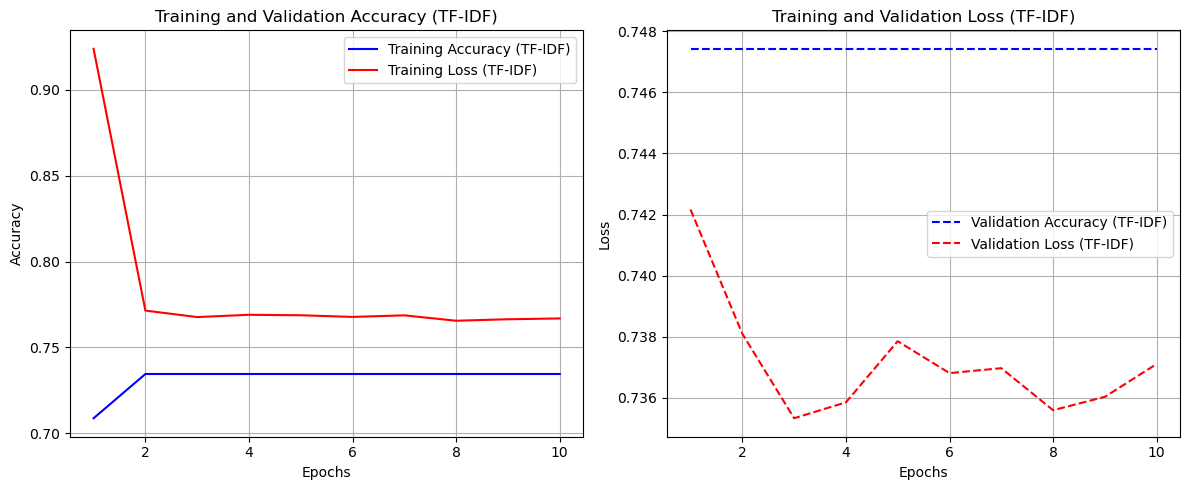

In [48]:
#plot
acc_tfidf = history.history['accuracy']
val_acc_tfidf = history.history['val_accuracy']
loss_tfidf = history.history['loss']
val_loss_tfidf = history.history['val_loss']
epochs_tfidf = range(1, len(acc_tfidf) + 1)

plt.figure(figsize=(12, 5))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_tfidf, acc_tfidf, 'b', label='Training Accuracy (TF-IDF)')
plt.plot(epochs_tfidf, loss_tfidf, 'r', label='Training Loss (TF-IDF)')
plt.title('Training and Validation Accuracy (TF-IDF)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_tfidf, val_acc_tfidf, 'b--', label='Validation Accuracy (TF-IDF)')
plt.plot(epochs_tfidf, val_loss_tfidf, 'r--', label='Validation Loss (TF-IDF)')
plt.title('Training and Validation Loss (TF-IDF)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<a id="models"></a>

<strong><center><h1><div class="top_section" style="background-color: Blue;">GloVe</div></h1></center></strong>

In [49]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

#Re-Import Datasets
file_path1 = '/Users/jane/Desktop/tripadvisor_hotel_reviews.csv'
df1 = pd.read_csv(file_path1) 
df1.head()

file_path2 = '/Users/jane/Desktop/booking_hotel_reviews_english.csv'
df2 = pd.read_csv(file_path2) 
df2.head()

processor = TextProcessor()

# Encoding and Data cleaning 
df1["label"] = df1["Rating"].apply(label_encode_1to5)
df1["label_name"] = df1["label"].apply(label2name_1to5)
df1["cleaned_review"] = df1["Review"].apply(lambda x: processor.process_text(remove_punct(x.lower())))

df2["label"] = df2["Review Rating"].apply(label_encode_1to10)
df2["label_name"] = df2["label"].apply(label2name_1to10)
df2["cleaned_review"] = df2["review"].apply(lambda x: processor.process_text(remove_punct(x.lower())))


#split dataset 1
X = df1['cleaned_review']
y = df1['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed_value)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # 确保 tokenizer 是在 X_train 上训练的


indices_to_augment = train_df.sample(frac=0.2).index  # 20% for augmentation 
train_df.loc[indices_to_augment, 'augmented_review'] = train_df.loc[indices_to_augment, 'cleaned_review'].apply(lambda x: augment_text(x, methods=methods_to_apply))

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)


# Tokenization
train_df['tokenized'] = train_df['cleaned_review'].apply(lambda x: x.split())
test_df['tokenized'] = test_df['cleaned_review'].apply(lambda x: x.split())

max_sequence_length = 1000 
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_sequence_length)



# Logistic Regression Mode

In [50]:
# Load GloVe embeddings
glove_embeddings = {}
embedding_dim = 100

with open('/Users/jane/Desktop/glove.6B/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector


# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print(len(X_train_pad), len(y_train))

18441 18441


In [51]:
# GloVe + Logistic Regression Model
glove_lr_model = LogisticRegression(max_iter=1000)
glove_lr_model.fit(X_train_pad, y_train)


y_train_pred_glove_lr = glove_lr_model.predict(X_train_pad)
train_accuracy_glove_lr = accuracy_score(y_train, y_train_pred_glove_lr)
print("GloVe + LR Train Accuracy:", train_accuracy_glove_lr)

y_pred_glove_lr = glove_lr_model.predict(X_test_pad)
accuracy_glove_lr = accuracy_score(y_test, y_pred_glove_lr)
print("GloVe + LR Test Accuracy:", accuracy_glove_lr)
print(classification_report(y_test, y_pred_glove_lr))

GloVe + LR Train Accuracy: 0.7446993113171737
GloVe + LR Test Accuracy: 0.7224390243902439
              precision    recall  f1-score   support

           0       0.13      0.02      0.03       309
           1       0.04      0.00      0.01       216
           2       0.74      0.97      0.84      1525

    accuracy                           0.72      2050
   macro avg       0.31      0.33      0.29      2050
weighted avg       0.58      0.72      0.63      2050



/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
# df2
X_df2_sequences = tokenizer.texts_to_sequences(df2['cleaned_review'])

X_df2_pad = pad_sequences(X_df2_sequences, maxlen=max_sequence_length)

y_df2_pred_glove_lr = glove_lr_model.predict(X_df2_pad)

accuracy_glove_lr_df2 = accuracy_score(df2['label'].values, y_df2_pred_glove_lr)
print("GloVe + LR Test Accuracy on df2:", accuracy_glove_lr_df2)
print(classification_report(df2['label'].values, y_df2_pred_glove_lr))


GloVe + LR Test Accuracy on df2: 0.7832699619771863
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
           1       0.00      0.00      0.00       576
           2       0.78      1.00      0.88      2678

    accuracy                           0.78      3419
   macro avg       0.26      0.33      0.29      3419
weighted avg       0.61      0.78      0.69      3419



/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
#table
glove_lr_data = pd.DataFrame ({
    'Model': 'GloVe + LR',
    'df1 Train Accuracy': [f'{train_accuracy_glove_lr*100:.2f}%'], 
    'df1 Test Accuracy': [f'{accuracy_glove_lr*100:.2f}%'],        
    'df2 Test Accuracy': [f'{accuracy_glove_lr_df2*100:.2f}%']    
})

accuracy_data_percentage = pd.concat([accuracy_data_percentage, glove_lr_data], ignore_index=True)

accuracy_data_percentage


,Model,df1 Train Accuracy,df1 Test Accuracy,df2 Test Accuracy
0,Word2Vec + LR,84.58%,85.76%,83.91%
1,Word2Vec + DL,83.47%,85.09%,72.80%
2,TF-IDF + LR,87.52%,85.66%,71.34%
3,TF-IDF + DL,97.87%,84.10%,65.46%
4,TF-IDF + CNN,73.45%,74.39%,65.46%
5,GloVe + LR,74.47%,72.24%,78.33%


# Deep Learning Model

In [54]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_pad, train_df['label'].values, test_size=0.1, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=max_sequence_length, trainable=False))
model.add(LSTM(128))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=19, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/19
260/260 [==============================] - 206s 789ms/step - loss: 0.6611 - accuracy: 0.7472 - val_loss: 0.7061 - val_accuracy: 0.7312
Epoch 2/19
260/260 [==============================] - 204s 784ms/step - loss: 0.5252 - accuracy: 0.8054 - val_loss: 0.4917 - val_accuracy: 0.8217
Epoch 3/19
260/260 [==============================] - 204s 783ms/step - loss: 0.4386 - accuracy: 0.8351 - val_loss: 0.4517 - val_accuracy: 0.8298
Epoch 4/19
260/260 [==============================] - 204s 783ms/step - loss: 0.3927 - accuracy: 0.8500 - val_loss: 0.4321 - val_accuracy: 0.8379
Epoch 5/19
260/260 [==============================] - 1085s 4s/step - loss: 0.3744 - accuracy: 0.8539 - val_loss: 0.4207 - val_accuracy: 0.8374
Epoch 6/19
260/260 [==============================] - 222s 856ms/step - loss: 0.3501 - accuracy: 0.8635 - val_loss: 0.4343 - val_accuracy: 0.8450
Epoch 7/19
260/260 [==============================] - 222s 853ms/step - loss: 0.3310 - accuracy: 0.8703 - val_loss: 0.4178 - v

In [55]:
# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred_dl = np.argmax(y_pred_prob, axis=-1)
accuracy_dl = accuracy_score(y_test, y_pred_dl)
print("GloVe + LSTM Test Accuracy:", accuracy_dl)
print(classification_report(y_test, y_pred_dl))


58/58 [==============================] - 10s 169ms/step
GloVe + LSTM Test Accuracy: 0.8287262872628727
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       294
           1       0.36      0.28      0.31       202
           2       0.89      0.94      0.91      1349

    accuracy                           0.83      1845
   macro avg       0.67      0.64      0.66      1845
weighted avg       0.82      0.83      0.82      1845



In [56]:
# df2
X_df2 = tokenizer.texts_to_sequences(df2['cleaned_review'])

X_df2_pad = pad_sequences(X_df2, maxlen=max_sequence_length, padding='post')

y_df2_pred_prob = model.predict(X_df2_pad)

y_df2_pred = np.argmax(y_df2_pred_prob, axis=-1)

accuracy_df2 = accuracy_score(df2['label'].values, y_df2_pred)
print("Model Test Accuracy on df2:", accuracy_df2)
print(classification_report(df2['label'].values, y_df2_pred))



107/107 [==============================] - 18s 171ms/step
Model Test Accuracy on df2: 0.048259725065808716
              precision    recall  f1-score   support

           0       0.05      1.00      0.09       165
           1       0.00      0.00      0.00       576
           2       0.00      0.00      0.00      2678

    accuracy                           0.05      3419
   macro avg       0.02      0.33      0.03      3419
weighted avg       0.00      0.05      0.00      3419



/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jane/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
#table
train_accuracy_df1 = history.history['accuracy'][-1] * 100  
glove_dl_data = pd.DataFrame({
    'Model': 'GloVe + LSTM',
    'df1 Train Accuracy': [f'{train_accuracy_df1:.2f}%'],
    'df1 Test Accuracy': [f'{accuracy_dl*100:.2f}%'],         
    'df2 Test Accuracy': [f'{accuracy_df2*100:.2f}%']        
})

accuracy_data_percentage = pd.concat([accuracy_data_percentage, glove_dl_data], ignore_index=True)

accuracy_data_percentage



,Model,df1 Train Accuracy,df1 Test Accuracy,df2 Test Accuracy
0,Word2Vec + LR,84.58%,85.76%,83.91%
1,Word2Vec + DL,83.47%,85.09%,72.80%
2,TF-IDF + LR,87.52%,85.66%,71.34%
3,TF-IDF + DL,97.87%,84.10%,65.46%
4,TF-IDF + CNN,73.45%,74.39%,65.46%
5,GloVe + LR,74.47%,72.24%,78.33%
6,GloVe + LSTM,98.77%,82.87%,4.83%


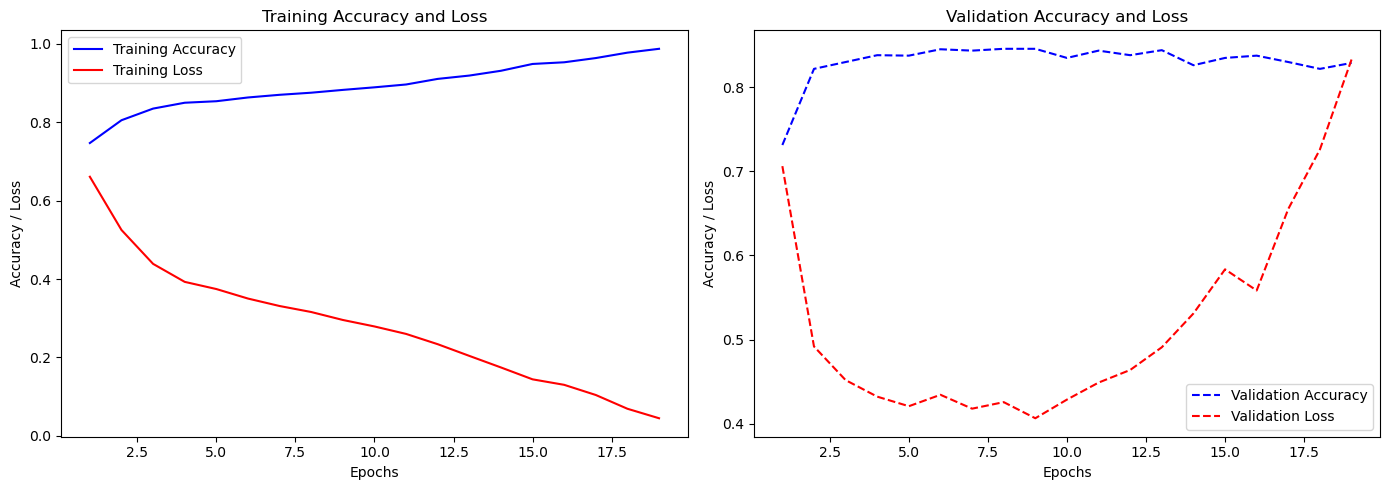

In [62]:
#plot

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, train_acc, 'b', label='Training Accuracy')
ax1.plot(epochs, train_loss, 'r', label='Training Loss')
ax1.set_title('Training Accuracy and Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy / Loss')
ax1.legend()

ax2.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
ax2.plot(epochs, val_loss, 'r--', label='Validation Loss')
ax2.set_title('Validation Accuracy and Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy / Loss')
ax2.legend()

plt.tight_layout()
plt.show()


<a id="models"></a>

<strong><center><h1><div class="top_section" style="background-color: Orange;">BERT Mini - Experimental</div></h1></center></strong>

In [63]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

file_path1 = '/Users/jane/Desktop/tripadvisor_hotel_reviews.csv'
df1 = pd.read_csv(file_path1)

file_path2 = '/Users/jane/Desktop/booking_hotel_reviews_english.csv'
df2 = pd.read_csv(file_path2)

processor = TextProcessor()

# Cleaning and encoding 
df1["label"] = df1["Rating"].apply(label_encode_1to5)
df1["cleaned_review"] = df1["Review"].apply(lambda x: processor.process_text(x))

df2["label"] = df2["Review Rating"].apply(label_encode_1to10)
df2["cleaned_review"] = df2["review"].apply(lambda x: processor.process_text(x))

# Split
X_train_df1, X_test_df1, y_train_df1, y_test_df1 = train_test_split(df1['cleaned_review'], df1['label'], test_size=0.1, random_state=seed_value)
X_df2 = df2['cleaned_review']
y_df2 = df2['label'].values

In [64]:
tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')
model = MobileBertModel.from_pretrained('google/mobilebert-uncased')

encoded_data_train_df1 = tokenizer.batch_encode_plus(
    X_train_df1.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length',
    max_length=256, 
    truncation=True,
    return_tensors='pt'
)

encoded_data_test_df1 = tokenizer.batch_encode_plus(
    X_test_df1.tolist(), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length',
    max_length=256, 
    truncation=True,
    return_tensors='pt'
)

#feature extraction 
input_ids_train_df1 = encoded_data_train_df1['input_ids']
attention_masks_train_df1 = encoded_data_train_df1['attention_mask']
input_ids_test_df1 = encoded_data_test_df1['input_ids']
attention_masks_test_df1 = encoded_data_test_df1['attention_mask']

y_train_tensor_df1 = torch.tensor(y_train_df1.values)
y_test_tensor_df1 = torch.tensor(y_test_df1.values)

train_dataset_df1 = TensorDataset(input_ids_train_df1, attention_masks_train_df1, y_train_tensor_df1)
test_dataset_df1 = TensorDataset(input_ids_test_df1, attention_masks_test_df1, y_test_tensor_df1)

batch_size = 32

train_data_loader_df1 = DataLoader(train_dataset_df1, batch_size=batch_size, shuffle=True)
test_data_loader_df1 = DataLoader(test_dataset_df1, batch_size=batch_size, shuffle=False)


In [66]:
import torch
from torch import nn
from transformers import MobileBertForSequenceClassification
from torch.optim import Adam
 
# initialize model 
num_classes = 3

model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=num_classes)

model.config.num_labels = num_classes
model.classifier = nn.Linear(model.config.hidden_size, num_classes)

for name, param in model.named_parameters():
    if 'classifier' not in name: 
        param.requires_grad = False

#for param in model.classifier.parameters():
    #param.requires_grad = True
    
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
def train_model(model, data_loader, loss_fn, optimizer, device, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d[0].to(device)
        attention_mask = d[1].to(device)
        labels = d[2].to(device)

        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = loss_fn(logits, labels)
        
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d[0].to(device)
            attention_mask = d[1].to(device)
            labels = d[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = loss_fn(logits, labels)
            
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 4

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)
    
    train_acc, train_loss = train_model(
        model,
        train_data_loader_df1,  
        loss_fn,
        optimizer,
        device,
        len(train_dataset_df1)
    )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        test_data_loader_df1, 
        loss_fn,
        device,
        len(test_dataset_df1)
    )
    
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

Epoch 1/4
----------
Train loss 341304.372587366 accuracy 0.5722574697684507
Val loss 169408.0535456731 accuracy 0.7439024390243902

Epoch 2/4
----------
Train loss 90689.44382353837 accuracy 0.5755110894203135
Val loss 162833.1453125 accuracy 0.10536585365853658

Epoch 3/4
----------
Train loss 86797.0157130091 accuracy 0.5745350035247546
Val loss 90137.60640024039 accuracy 0.7439024390243902

Epoch 4/4
----------
Train loss 100794.57263458622 accuracy 0.5709017949135079
Val loss 217091.9477764423 accuracy 0.7439024390243902

